In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.linear_model import LinearRegression
import os
from pathlib import Path
import matplotlib.ticker as ticker

 
# Changing the CWD
os.chdir('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_helper')
from interp_df import *

In [2]:
# =====================
# Funciton for plotting
# =====================
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels)
    return(handles, labels)

# Define a function to compute the IQR
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

In [3]:
# Read compounds and each flight dataframe
Flight_IDs   = ['P-3B', 'RF03', 'FN19']
Flight_IDs   = ['RF03', 'RF07', 'RF09', 'FN19','P-3B']

# dictionary for flights 
id2fire_name = {'RF01': '2018-07-24 Rattlesnake Creek Fire\n(WE-CAN)',
                'RF02': '2018-07-26 Carr Fire\n(WE-CAN)',
                'RF03': '2018-07-30 Taylor Creek\n(WE-CAN)',
                'RF04': '2018-07-31 Sharps Fire\n(WE-CAN)',
                'RF05': '2018-08-02 Mendocino Complex Fire\n(WE-CAN)',
                'RF06': '2018-08-03 Three fires\n(WE-CAN)',
                'RF07': '2018-08-06 Donnell Fire\n(WE-CAN)',
                #'RF08': '2018-08-08 Mendocino Complex Fire\n(WE-CAN)',
                'RF09': '2018-08-09 Bear Trap Fire\n(WE-CAN)',
                'RF10': '2018-08-13 Five Fires\n(WE-CAN)',
                'RF11': '2018-08-15 Four Fires\n(WE-CAN)',
                #'RF12': '2018-08-16 Miriam Fire\n(WE-CAN)',
                'RF13': '2018-08-20 Two Fires\n(WE-CAN)',
                #'RF15': '2018-08-28 South Sugarloaf Fire\n(WE-CAN)',
                'RF18': '2018-09-10 Red Feather Lakes Rx Fire\n(WE-CAN)',
                'RF19': '2018-09-13 Silver Creek Fire\n(WE-CAN)',
                'P-3B': '2013-09-23 Managed Understory Fire\n(DISCOVER-AQ)',
                'FN19': '2019-08-30 Black Water Fire\n(FIREX-AQ)'}

name2uncertainty = {"Formaldehyde": 0.4,
                    "Acetaldehyde": 0.15,
                    "Acetone": 0.15,
                    "Formic acid": 0.5,
                    "Acetic acid": 0.5,
                    "O3": 0.02,
                    "NOx": 0.04,
                    "PAN": 0.12}

# diff calcualiton 
diff_set = 'median'
#diff_set = 'mean'
# setting for smk or bkg
get_smk      = False 
get_smk_dil  = True
# setting up postfic name
if get_smk:      postfix = 'smk'
if get_smk_dil:  postfix = 'smk_dil'

This is diff between MCM driven by CTM VOCs and CTM chemical mechanism (min) 25ppb (8%) 5.0809643111672536 4.668875531583497
This is diff between MCM driven by CTM VOCs and CTM chemical mechanism (min) -0ppb (-0%) 2.544163106239751 2.5428677021775363
This is diff between MCM driven by CTM VOCs and CTM chemical mechanism (min) -0ppb (-0%) 1.1002308405975876 1.1052264762897381
This is diff between MCM driven by CTM VOCs and CTM chemical mechanism (min) 31ppb (42%) 1.5736692684014566 1.0495187652252072
This is diff between MCM driven by CTM VOCs and CTM chemical mechanism (min) 2ppb (14%) 0.30420587891935763 0.26445451862327657


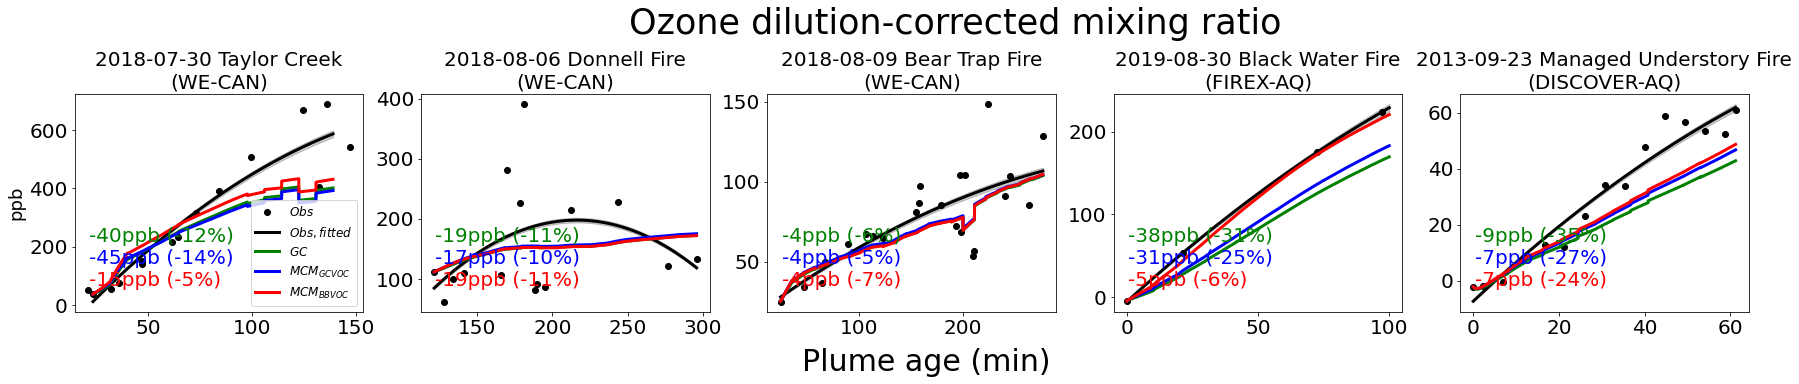

In [4]:
# diff calcualiton 
diff_set = 'median'
#diff_set = 'mean'

### Isoprene and MVK are okay


# HNO3 is only measured in WE-CAN
# PAN is measured in WE-CAN and FIREX-AQ

# plotting for the figure
linewidth = 3
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_lable  = 12
fontsize_comp   = 18

# colors for model
colors = ['green', 'purple', 'orange', \
          'red', 'blue']

compound = 'O3'

# subplots 
fig, axes = plt.subplots(1, len(Flight_IDs), 
                         figsize=(6*len(Flight_IDs), 4),
                         sharex='col')
for col, Flight_ID in enumerate(Flight_IDs):
    shaded_uncertainty = name2uncertainty.get(compound, 0.15)
    # auto change for each flight ID
    if Flight_ID in ['RF03', 'RF07', 'RF09']: file_prefix  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['FN19']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['P-3B']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
    file_obs = file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_obs_' + postfix +'.csv'
    path = Path(file_obs)

    # read in data
    if path.is_file():
        df_compound_obs = pd.read_csv(file_obs, index_col=0)
        df_compound_obs.index.name='Avg_physical_age_min'
    else:
        df_dummy = pd.read_csv(file_prefix + 'O3' + '/'+ Flight_ID + '_obs_' + postfix +'.csv', index_col=0)
        df_compound_obs = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])

    # remove the outliner for WE-CAN RF03
    if col == 1:
        df_compound_obs = df_compound_obs.iloc[df_compound_obs.index != 124.7217351]

    # reading model
    df_compound_mod = pd.read_csv(file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_mod_' + postfix +'.csv', index_col=0)
    df_compound_mod.index.name='Avg_physical_age_min'

    if path.is_file() and df_compound_obs['Observation'].values[0] != 0:
        # polinomial regression line
        # train the model based on observation data
        idx = np.isfinite(df_compound_obs.index) & np.isfinite(df_compound_obs['Observation'])         # only pass datapoint with values
        if Flight_ID in ['FN19', 'RF03','RF07', 'RF09']: coefs = np.polyfit(df_compound_obs.index[idx], df_compound_obs['Observation'][idx], 2) # 3 may be the best fit
        if Flight_ID in ['P-3B']: coefs = np.polyfit(df_compound_obs.index[idx], df_compound_obs['Observation'][idx], 2) # 3 may be the best fit
        poly_model = np.poly1d(coefs)

        # plotting scatter
        axes[col].scatter(df_compound_obs.index, df_compound_obs['Observation'], label = '$Obs$', color = 'black')

        # plotting the line of best fit
        axes[col].plot(df_compound_mod.index, poly_model(df_compound_mod.index), \
        #                    color='black', label = 'Observation, fitted', linewidth=linewidth)
                            color='black', label = '$Obs, fitted$', linewidth=linewidth)
        axes[col].fill_between(df_compound_mod.index, poly_model(df_compound_mod.index)*(1-shaded_uncertainty), poly_model(df_compound_mod.index)*(1+shaded_uncertainty), color='black',
                             alpha=0.2)

    # MCM
    axes[col].plot(df_compound_mod.index, df_compound_mod['GEOS-Chem (base)'],\
                        color=colors[0],  label='$GC$', linewidth=linewidth)
    axes[col].plot(df_compound_mod.index, df_compound_mod['MCM + GEOS-Chem VOCs'], \
                        color=colors[4],  label='$MCM_{GCVOC}$', linewidth=linewidth)  
    axes[col].plot(df_compound_mod.index, df_compound_mod['MCM + FUR'], \
                        color=colors[3],  label='$MCM_{BBVOC}$', linewidth=linewidth) 

    # set up the row
    axes[col].set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight)

    # y label, unit
    if col==0: axes[col].set_ylabel('ppb', size=fontsize_comp)

    # Spacing Out
    plt.subplots_adjust(wspace=.20, hspace=.10)
    axes[col].tick_params(axis='both', labelsize=fontsize_tick)

    # Display labels in the figure
    if col == 0:
        font = font_manager.FontProperties(size=fontsize_lable, weight='semibold')
        # edit part
        handles, labels= reorderLegend(axes[col],['$Obs$', '$Obs, fitted$', \
                                                       '$GC$', '$MCM_{GCVOC}$', '$MCM_{BBVOC}$'])
        axes[col].legend(loc="lower right", prop=font, handles= handles, labels=labels)

    # Texts
    if len(Flight_IDs) == 3 and col == 1:
        t = plt.text(0.55,1.4, 'Ozone dilution-corrected mixing ratio', transform=axes[col].transAxes,horizontalalignment='center', verticalalignment='top', fontsize=35)
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    if len(Flight_IDs) == 5 and col == 2:
        t = plt.text(0.65,1.4, 'Ozone dilution-corrected mixing ratio', transform=axes[col].transAxes,horizontalalignment='center', verticalalignment='top', fontsize=35)
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    if len(Flight_IDs) == 3 and col == 1:
        t = plt.text(0.45,-0.3, 'Plume age (min)', transform=axes[col].transAxes,horizontalalignment='center', verticalalignment='bottom', fontsize=30)
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    if len(Flight_IDs) == 5 and col == 2:
        t = plt.text(0.55,-0.3, 'Plume age (min)', transform=axes[col].transAxes,horizontalalignment='center', verticalalignment='bottom', fontsize=30)
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    # edit part, uncomment when we compare MCM+Furan and MCM, with CTM VOCs
    # get the range for the x/y axis
    xmin, xmax = axes[col].get_xlim()
    ymin, ymax = axes[col].get_ylim()


    # text for observations
    if path.is_file() and df_compound_obs['Observation'].values[0] != 0:
        relative_diff1 = (df_compound_mod['GEOS-Chem (base)']-poly_model(df_compound_mod.index))/poly_model(df_compound_mod.index) * 100       
        relative_diff1 = relative_diff1
        abs_diff1 = df_compound_mod['GEOS-Chem (base)']-poly_model(df_compound_mod.index)

        relative_diff3 = (df_compound_mod['MCM + GEOS-Chem VOCs']-poly_model(df_compound_mod.index))/poly_model(df_compound_mod.index) * 100
        relative_diff3 = relative_diff3
        abs_diff3 = df_compound_mod['MCM + GEOS-Chem VOCs']-poly_model(df_compound_mod.index)

        relative_diff4 = (df_compound_mod['MCM + FUR']-poly_model(df_compound_mod.index))/poly_model(df_compound_mod.index) * 100
        relative_diff4 = relative_diff4 
        abs_diff4 = df_compound_mod['MCM + FUR']-poly_model(df_compound_mod.index)

        # median of the diff
        relative_diff1 = np.nanmedian(relative_diff1)
        relative_diff3 = np.nanmedian(relative_diff3)
        relative_diff4 = np.nanmedian(relative_diff4)
        abs_diff1 = np.nanmedian(abs_diff1)
        abs_diff3 = np.nanmedian(abs_diff3)
        abs_diff4 = np.nanmedian(abs_diff4)

        # last data point of the diff
        diff_str1   = '{:.0f}'.format(abs_diff1) + 'ppb (' + '{:.0f}'.format(relative_diff1) +'%)'
        diff_str3   = '{:.0f}'.format(abs_diff3) + 'ppb (' + '{:.0f}'.format(relative_diff3) +'%)'
        diff_str4   = '{:.0f}'.format(abs_diff4) + 'ppb (' + '{:.0f}'.format(relative_diff4) +'%)'

        axes[col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.32+ymin, diff_str1, fontsize=fontsize_tick, color = colors[0])  
        axes[col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.22+ymin, diff_str3, fontsize=fontsize_tick, color = colors[4])  
        axes[col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.12+ymin, diff_str4, fontsize=fontsize_tick, color = colors[3])  

    # text for model vs model
    variant_simu = 'MCM + GEOS-Chem VOCs'
    variant_simu = 'MCM + FUR'
    relative_diff = (df_compound_mod[variant_simu]-df_compound_mod['GEOS-Chem (base)'])/df_compound_mod['GEOS-Chem (base)'] * 100
    abs_diff = df_compound_mod[variant_simu]-df_compound_mod['GEOS-Chem (base)']

    if diff_set == 'median':
        # MCM and GC, median of the diff
        relative_diff = np.nanmedian(relative_diff)
        abs_diff = np.nanmedian(abs_diff)
    if diff_set == 'mean':
        # MCM and GC, mean of the diff
        relative_diff = np.nanmean(relative_diff)
        abs_diff = np.nanmean(abs_diff)
    diff_str   = '{:.0f}'.format(abs_diff) + 'ppb (' + '{:.0f}'.format(relative_diff) +'%)'
    if diff_set == 'median':
        print('This is diff between MCM driven by CTM VOCs and CTM chemical mechanism (min)',  diff_str, 
              np.median(df_compound_mod[variant_simu])/60.0, np.median(df_compound_mod['GEOS-Chem (base)'])/60.0)
    if diff_set == 'mean':
        print('This is diff between MCM driven by CTM VOCs and CTM chemical mechanism (min)',  diff_str, 
              np.mean(df_compound_mod[variant_simu])/60.0, np.mean(df_compound_mod['GEOS-Chem (base)'])/60.0)       
#  Align the first column of axes:
fig.align_ylabels(axes[0])

Text(0.09, 0.5, 'Molecule cm$^{-3}$ ')

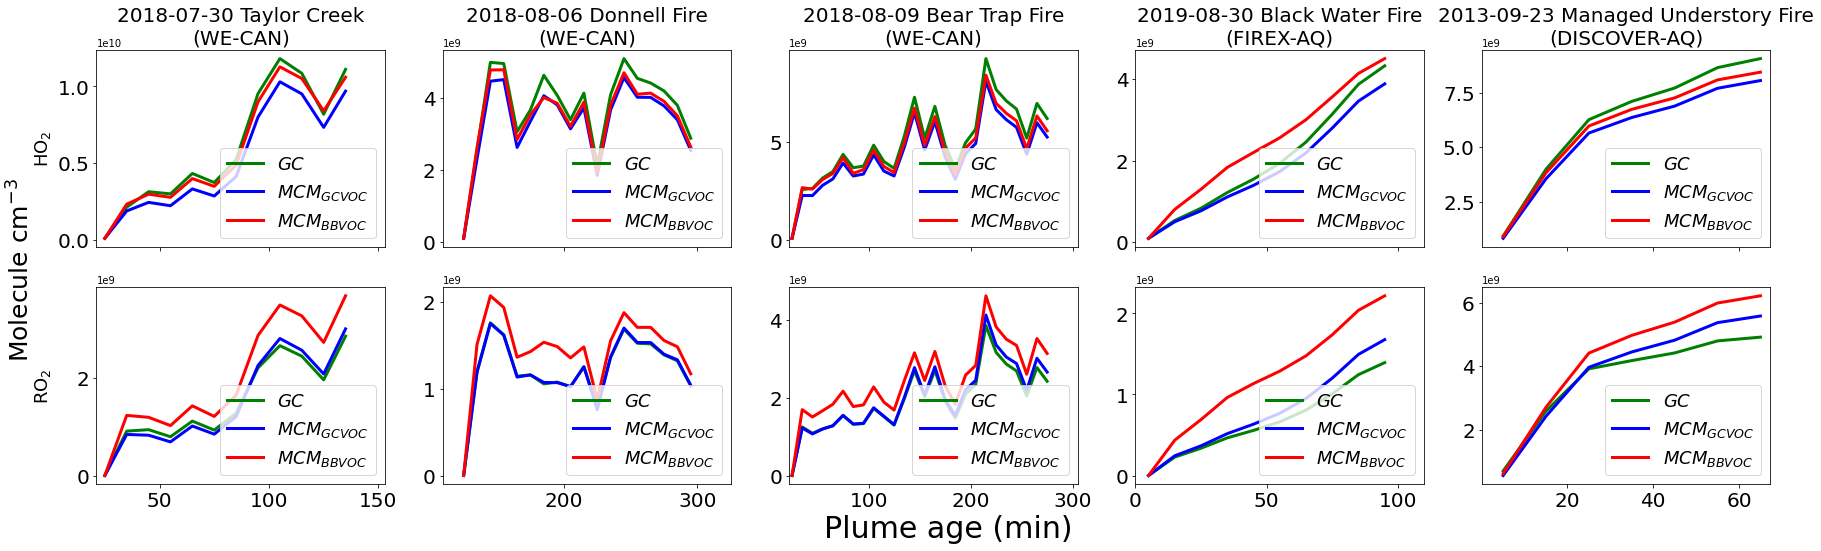

In [28]:
compounds = ['HO2', 'TRO2']
# plotting for the figure
linewidth = 3
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_label = 12
fontsize_comp   = 18

# colors for model
colors = ['green', 'purple', 'orange', \
          'red', 'blue']
# subplots 
fig, axes = plt.subplots(len(compounds), len(Flight_IDs), 
                         figsize=(6*len(Flight_IDs), 4*len(compounds)),
                         sharex='col')
for row, compound in enumerate(compounds):
    for col, Flight_ID in enumerate(Flight_IDs):
        shaded_uncertainty = name2uncertainty.get(compound, 0.15)
        # ------------
        # Reading data
        # ------------
        # auto change for each flight ID
        if Flight_ID in ['RF03','RF07', 'RF09']: file_prefix  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['FN19']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['P-3B']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
        file_obs = file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_obs_' + postfix +'.csv'
        path = Path(file_obs)
        
        # read in data
        if path.is_file():
            df_compound_obs = pd.read_csv(file_obs, index_col=0)
            df_compound_obs.index.name='Avg_physical_age_min'
        else:
            df_dummy = pd.read_csv(file_prefix + 'O3' + '/'+ Flight_ID + '_obs_' + postfix +'.csv', index_col=0)
            df_compound_obs = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
        
        # reading model
        df_compound_mod = pd.read_csv(file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_mod_' + postfix +'.csv', index_col=0)
        df_compound_mod.index.name='Avg_physical_age_min'
        
        # Fix the unit of modelled radicals and fix the data by removing the first second 
        df_compound_mod = df_compound_mod*2.46*1e10

        # ------------------------
        # Bin the Time and get IQR
        # ------------------------
        # Create bin edges for every X minutes
        interval_X = 10
        bin_edges = np.arange(0, df_compound_mod.index.max() + interval_X, interval_X)
        # Use the `cut` function to bin the data
        df_compound_mod['time_bin'] = pd.cut(df_compound_mod.index, bins=bin_edges, labels=bin_edges[:-1] + interval_X/2, right=False)
        # Group by the time bin and compute median and IQR for each bin
        binned_mod_stats = df_compound_mod.groupby('time_bin').agg(['median', iqr])
        # clean data
        binned_mod_stats = binned_mod_stats.dropna(how='all')
            
        # --------
        # Plotting
        # --------
        axes[row, col].plot(binned_mod_stats.index.tolist(), binned_mod_stats['GEOS-Chem (base)', 'median'], \
                            color= colors[0], label='$GC$', linewidth=linewidth)          
        axes[row, col].plot(binned_mod_stats.index, binned_mod_stats['MCM + GEOS-Chem VOCs', 'median'], 
                            color=colors[4],  label='$MCM_{GCVOC}$', linewidth=linewidth)  
        axes[row, col].plot(binned_mod_stats.index, binned_mod_stats['MCM + FUR', 'median'],
                            color=colors[3],  label='$MCM_{BBVOC}$', linewidth=linewidth)
        # ------------
        # Plot setting
        # ------------
        # set up the row
        if row == 0: axes[row, col].set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight)
    
        # Legend
        if (row, col) == (0, 0):
            font = font_manager.FontProperties(size=fontsize_label*1.5, weight='semibold')
        handles, labels= reorderLegend(axes[row, col],['$Obs$', '$Obs, fitted$', \
                                                  '$GC$', '$MCM_{GCVOC}$', '$MCM_{BBVOC}$'])
        axes[row, col].legend(loc="lower right", prop=font, handles= handles, labels=labels)
            
        # x and y ticks
        axes[row, col].tick_params(axis='both', labelsize=fontsize_tick)
        if col==0: 
            if compound == 'HO2': axes[row, col].set_ylabel('HO$_{2}$', size=fontsize_comp)
            if compound == 'TRO2': axes[row, col].set_ylabel('RO$_{2}$', size=fontsize_comp)
        # Texts
        if len(Flight_IDs) == 3 and col == 1 and row == len(compounds)-1 :
            t = plt.text(0.45,-0.3, 'Plume age (min)', transform=axes[row, col].transAxes,horizontalalignment='center', verticalalignment='bottom', fontsize=30)
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
        if len(Flight_IDs) == 5 and col == 2 and row == len(compounds)-1 :
            t = plt.text(0.55,-0.3, 'Plume age (min)', transform=axes[row, col].transAxes,horizontalalignment='center', verticalalignment='bottom', fontsize=30)
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
        # edit part, uncomment when we compare MCM+Furan and MCM, with CTM VOCs
        # get the range for the x/y axis
        xmin, xmax = min(df_compound_mod.index)*0.9, max(df_compound_mod.index)*1.1
        axes[row, col].set_xlim([xmin, xmax]) 


#  Align the first column of axes:
fig.align_ylabels(axes[:,0])

# Unit
unit='Molecule cm$^{-3}$ '
fig.text(0.09,0.5, unit, ha="center", va="center", rotation=90, fontsize=25)


In [ ]:
Flight_IDs = ['RF03', 'RF07', 'RF09']

compounds = ['HO2', 'TRO2']
# plotting for the figure
linewidth = 3
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_label = 12
fontsize_comp   = 18

# colors for model
#colors = ['green', 'orange', 'purple', \
#          'red', 'blue']
colors = ['green', 'purple', 'orange', \
          'red', 'blue']
# subplots 
fig, axes = plt.subplots(len(compounds), len(Flight_IDs), 
                         figsize=(6*len(Flight_IDs), 4*len(compounds)),
                         sharex='col')
for row, compound in enumerate(compounds):
    for col, Flight_ID in enumerate(Flight_IDs):
        shaded_uncertainty = name2uncertainty.get(compound, 0.15)
        # ------------
        # Reading data
        # ------------
        # Auto change for each flight ID
        if Flight_ID in ['RF03','RF07', 'RF09']: file_prefix  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['FN19']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['P-3B']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
        file_obs = file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_obs_' + postfix +'.csv'
        path = Path(file_obs)
        
        # Read in data
        if path.is_file():
            df_compound_obs = pd.read_csv(file_obs, index_col=0)
            df_compound_obs.index.name='Avg_physical_age_min'
        else:
            df_dummy = pd.read_csv(file_prefix + 'O3' + '/'+ Flight_ID + '_obs_' + postfix +'.csv', index_col=0)
            df_compound_obs = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
        
        # Reading model
        df_compound_mod = pd.read_csv(file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_mod_' + postfix +'.csv', index_col=0)
        df_compound_mod.index.name='Avg_physical_age_min'
        
        # Fix the unit of modelled radicals and fix the data by removing the first second 
        df_compound_mod = df_compound_mod*2.46*1e10

        # ------------------------
        # Bin the Time and get IQR
        # ------------------------
        # Create bin edges for every X minutes
        interval_X = 10
        bin_edges = np.arange(0, df_compound_mod.index.max() + interval_X, interval_X)
        # Use the `cut` function to bin the data
        df_compound_mod['time_bin'] = pd.cut(df_compound_mod.index, bins=bin_edges, labels=bin_edges[:-1] + interval_X/2, right=False)
        # Group by the time bin and compute median and IQR for each bin
        binned_mod_stats = df_compound_mod.groupby('time_bin').agg(['median', iqr])
        # Clean data
        binned_mod_stats = binned_mod_stats.dropna(how='all')

        # ----------------------------
        # HO2 or RO2 from missing VOCs
        # ----------------------------
        binned_mod_stats['Diff pct', 'median'] = (binned_mod_stats['MCM + FUR', 'median'] - binned_mod_stats['MCM + GEOS-Chem VOCs', 'median'])/binned_mod_stats['MCM + FUR', 'median']*100
        binned_mod_stats['Diff', 'median']     = binned_mod_stats['MCM + FUR', 'median'] - binned_mod_stats['MCM + GEOS-Chem VOCs', 'median']

        # --------
        # Plotting
        # --------

        
        
        
        axes[row, col].plot(binned_mod_stats.index, binned_mod_stats['MCM + FUR', 'median'],
                            color='black',  label="$MCM_{BBVOC}$", linewidth=linewidth)
        #axes[row, col].plot(binned_mod_stats.index, binned_mod_stats['Diff', 'median'],
        #                    color=colors[4],  label="$MCM_{BBVOC}$ - $MCM_{GCVOC}$", linewidth=linewidth)
        axes[row, col].plot(binned_mod_stats.index, [np.nan]*len(binned_mod_stats.index),
                            color=colors[4],  label="$MCM_{BBVOC}$ - $MCM_{GCVOC}$", linewidth=linewidth)
        '''
        
        # Calculate the total range of x values for the current subplot.
        x_range = df_compound_mod.index.max() - df_compound_mod.index.min()
        # Adjust the bar width based on the ratio of the current x_range to the maximum x_range of all subplots.
        adjusted_bar_width = 0.05 * (x_range)
        axes[row, col].bar(binned_mod_stats.index, binned_mod_stats['MCM + FUR', 'median'],
                           color=colors[3], label="$MCM_{BBVOC}$", width=adjusted_bar_width)  # Adjust the width as needed
        axes[row, col].plot(binned_mod_stats.index, [np.nan]*len(binned_mod_stats.index),
                            color=colors[4],  label="$MCM_{BBVOC}$ - $MCM_{GCVOC}$", linewidth=linewidth)
        '''
        
        # Put the right axis right here to show labels in axis
        ax_right = axes[row, col].twinx()
        ax_right.spines['right'].set_color('blue')  # Set the color of the right axis spine to blue
        ax_right.tick_params(axis='y', colors='blue')  # Set the tick color to blue
        
        # Set up fraction plotting
        ax_right.plot(binned_mod_stats.index ,binned_mod_stats['Diff pct', 'median'], 
                                color = 'blue', label='The fraction from missing VOCs', linewidth=linewidth)
    
        # x and y tick
        ax_right.tick_params(axis='both', labelsize=fontsize_tick)
        # mute the right
        #ax_right.set_visible(False)
        
        
        # ------------
        # Plot setting
        # ------------
        # Set up the row
        if row == 0: axes[row, col].set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight)
        axes[row, col].tick_params(axis='both', labelsize=fontsize_tick)

        # Display labels in the figure
        if (row, col) == (0, 0): font = font_manager.FontProperties(size=fontsize_label*1.2, weight='semibold')
        handles, labels= reorderLegend(axes[row, col],["$MCM_{BBVOC}$", \
                                                       "$MCM_{BBVOC}$ - $MCM_{GCVOC}$"])
        axes[row, col].legend(loc="lower right", prop=font, handles= handles, labels=labels)

        # Texts
        if len(Flight_IDs) == 3 and col == 1 and row == len(compounds)-1 :
            t = plt.text(0.45,-0.3, 'Plume age (min)', transform=axes[row, col].transAxes,horizontalalignment='center', verticalalignment='bottom', fontsize=30)
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
        if len(Flight_IDs) == 5 and col == 2 and row == len(compounds)-1 :
            t = plt.text(0.55,-0.3, 'Plume age (min)', transform=axes[row, col].transAxes,horizontalalignment='center', verticalalignment='bottom', fontsize=30)
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
        # Set up the y label
        if col==0: 
            if compound == 'HO2': axes[row, col].set_ylabel('HO$_{2}$', size=fontsize_comp)
            if compound == 'TRO2': axes[row, col].set_ylabel('RO$_{2}$', size=fontsize_comp)

        # Get the range for the x/y axis
        xmin, xmax = min(df_compound_mod.index)*0.9, max(df_compound_mod.index)*1.1
        axes[row, col].set_xlim([xmin, xmax]) 

        # text for the NMB in the model
        Mean_X_frac = str(round(np.nanmean(binned_mod_stats['Diff pct', 'median'].median(),dtype='float32'))) + ' %'
        t = axes[row, col].text(0.15, 0.85, Mean_X_frac, transform = axes[row, col].transAxes, fontsize=fontsize_tick*1.2, ha='center', color='black')
        t.set_bbox(dict(facecolor='white', edgecolor='black', alpha=0.8, linewidth = linewidth))


#  Align the first column of axes:
fig.align_ylabels(axes[:,0])
# Spacing Out
fig.subplots_adjust(wspace=.30, hspace=.10)
# Texts
fig.text(0.08,0.5, "Molecule cm$^{-3}$", ha="center", va="center", rotation=90, fontsize=25)
fig.text(0.935,0.5, "% from omitted VOCs", color='blue', ha="center", va="center", rotation=270, fontsize=25)

CategoricalIndex([30.0, 60.0, 90.0], categories=[30.0, 60.0, 90.0], ordered=True, dtype='category', name='time_bin')